<a href="https://colab.research.google.com/github/rahulrajpr/natural_language_processing/blob/main/imdb_sentiments_analyis_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the Environment

> Get the helper functions ready

In [1]:
from IPython.core.display import clear_output
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/hf_requirements.txt
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
!pip install -r hf_requirements.txt
clear_output()

> Import the libraries

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import sys
import os
import random
import matplotlib.pyplot as plt
import helper_functions as hf
import warnings
warnings.filterwarnings('ignore')
print(f'Python version : {sys.version}\n')
print(f'Tensorflow version : {tf.__version__}')

Python version : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]

Tensorflow version : 2.12.0


# Loading the DataSet (From Tensorflow Datasets)

In [3]:
data, info = tfds.load(name = 'imdb_reviews', as_supervised = True, with_info = True)
clear_output()

> Splitting the data as Train and Test (TFDS DataSet)

In [4]:
train = data['train']
val = data['test']

print(train)
print(val)

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


> Converting the prefetched dataset as numpy array

In [5]:
train_sentences, train_labels = hf.prefetch_dataset_to_array(train)
val_sentences, val_labels = hf.prefetch_dataset_to_array(val)

train_sentences[:1], train_labels[:1]

Numpy arrays returned as --> (data, labels)
Numpy arrays returned as --> (data, labels)


(array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."],
       dtype='|S13704'),
 array([0]))

> Checking number of samples in the dataset

In [6]:
len(train_sentences), len(val_sentences)

(25000, 25000)

> Printing Some Random Samples

In [7]:
num_random_samples = 10
index_range = range(0,len(train_sentences))

random_indexes = random.sample(index_range,num_random_samples)
for ind in random_indexes:
  random_sample = train_labels[ind],train_sentences[ind]
  print(random_sample)

(0, b'This movie is all flash and no soul. The actors put a lot of passion into the numbers, but these numbers often didn\'t connect with the film and felt like stand-alone music videos. And no effort was made to make the numbers sound as if they were happening right there in front of you, every single one sounds like its coming from a studio, essentially sucking all the life from the songs. Off the stage the performances were all dull and unrealized, especially Hudson, who essentially plays the same angry, "strong" (she\'s stubborn and selfish) black woman we\'ve seen before. There was absolutely no depth to her character, nor any of the other female leads. Though I think the movie wants us to believe that Hudson\'s character faces hardship because of her weight, it is really her own refusal to do what\'s best for the team that lands her in trouble, making the end of the film totally meaningless. Hudson\'s Academy Award is a joke, there was no justification. When she sang, she put for

### Text Normaization

In [8]:
train_sentences = [hf.text_standardization(x) for x in train_sentences]
val_sentences = [hf.text_standardization(x) for x in val_sentences]

In [9]:
train_sentences[:3]

['this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it',
 'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the sette and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly 

### Tokenizing the Text

In [10]:
unique_words = len(set(''.join(train_sentences).split())) 

sentence_length_95th_precentile = int(np.percentile([len(x.split()) for x in train_sentences],95))

print(f'\n95th Percentile of the sentences length : {sentence_length_95th_precentile}\n')
print(f'Number of unique words in the training data :{unique_words}')


95th Percentile of the sentences length : 585

Number of unique words in the training data :155893


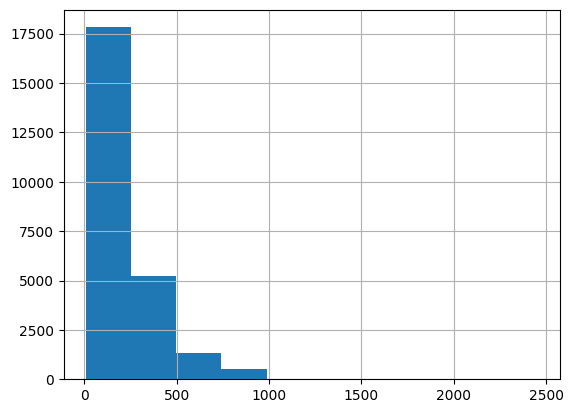

In [11]:
pd.Series([len(x.split()) for x in train_sentences]).hist();

In [12]:
BATCH_SIZE = 32

VOCAB_SIZE = 20000
OOV_TOKEN = '<OOV>'

PADDING_LEN = 224
PADDING_STYLE = 'post'
TRUNC_STYLE = 'post'

EMBED_LEN = 32

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token= OOV_TOKEN)

In [15]:
tokenizer.fit_on_texts(train_sentences)

In [16]:
train_sentences_tokenized = tokenizer.texts_to_sequences(train_sentences)
val_sentences_tokenized = tokenizer.texts_to_sequences(val_sentences)

In [17]:
len(train_sentences_tokenized),len(val_sentences_tokenized)

(25000, 25000)

### Padding the Sequences

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
train_sequences = pad_sequences(train_sentences_tokenized, maxlen = PADDING_LEN, padding = PADDING_STYLE, truncating = TRUNC_STYLE)
val_sequences = pad_sequences(val_sentences_tokenized, maxlen = PADDING_LEN, padding = PADDING_STYLE, truncating = TRUNC_STYLE)

train_sequences.shape, val_sequences.shape

((25000, 224), (25000, 224))

### Preparing Data Pipeline

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((train_sequences,train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_sequences,val_labels))

train_ds, train_ds

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(224,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(224,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [21]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Preparing the model

In [22]:
from tensorflow.keras import layers

In [23]:
def build_model(vocab_size,embedding_dim, rnn_units, batch_size, pad_length,model_name):
  
  inputs = tf.keras.Input(shape = [pad_length],name = 'input_layer')
  x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                       mask_zero = True, batch_input_shape = [batch_size, None])(inputs)
  x = layers.LSTM(units = rnn_units)(x)
  outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
  model = tf.keras.Model(inputs, outputs, name = model_name)
  return model

In [24]:
model_1 = build_model(vocab_size = VOCAB_SIZE,
                      embedding_dim = EMBED_LEN, rnn_units = 64, batch_size = BATCH_SIZE, 
                      pad_length = PADDING_LEN,
                      model_name = 'model_1')

model_1.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224)]             0         
                                                                 
 embedding (Embedding)       (None, 224, 32)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


# Model Training and Evaluation

In [25]:
history_1 = model_1.fit(train_ds, epochs = 10,
            steps_per_epoch = len(train_ds),
            validation_data = val_ds,
            validation_steps = len(val_ds),
            callbacks = [hf.create_model_checkpoint(monitor = 'val_accuracy', model_name = model_1.name)])

model_1.load_weights('checkpoints/model_1.h5')
model_1.evaluate(val_ds)

Epoch 1/10
782/782 [==============================] - 112s 130ms/step - loss: 0.4639 - accuracy: 0.7738 - val_loss: 0.3717 - val_accuracy: 0.8450
Epoch 2/10
782/782 [==============================] - 28s 36ms/step - loss: 0.2796 - accuracy: 0.8925 - val_loss: 0.3829 - val_accuracy: 0.8398
Epoch 3/10
782/782 [==============================] - 20s 26ms/step - loss: 0.1867 - accuracy: 0.9324 - val_loss: 0.3965 - val_accuracy: 0.8307
Epoch 4/10
782/782 [==============================] - 20s 26ms/step - loss: 0.1421 - accuracy: 0.9509 - val_loss: 0.4497 - val_accuracy: 0.8383
Epoch 5/10
782/782 [==============================] - 18s 23ms/step - loss: 0.1099 - accuracy: 0.9621 - val_loss: 0.5796 - val_accuracy: 0.8273
Epoch 6/10
782/782 [==============================] - 19s 25ms/step - loss: 0.0701 - accuracy: 0.9784 - val_loss: 0.6239 - val_accuracy: 0.8298
Epoch 7/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0466 - accuracy: 0.9852 - val_loss: 0.7200 - val_accurac

In [30]:
def calculate_results(model,val_ds):
  pred = np.squeeze(np.round(model_1.predict(val_ds)))
  y_true = np.array([x.numpy() for x in val_ds.unbatch().map(lambda x,y: y)])
  return hf.calculate_results(y_true = y_true , y_pred = pred)

In [32]:
results_1 = calculate_results(model_1, val_ds)
results_1

782/782 [==============================] - 5s 5ms/step


{'accuracy': 0.84496,
 'precision': 0.845064952747612,
 'recall': 0.84496,
 'f1': 0.8449482101099796}

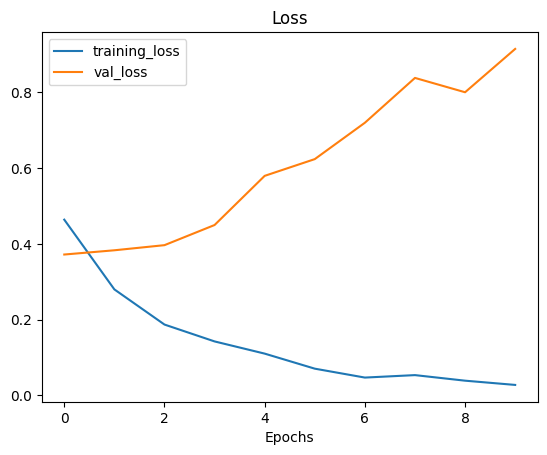

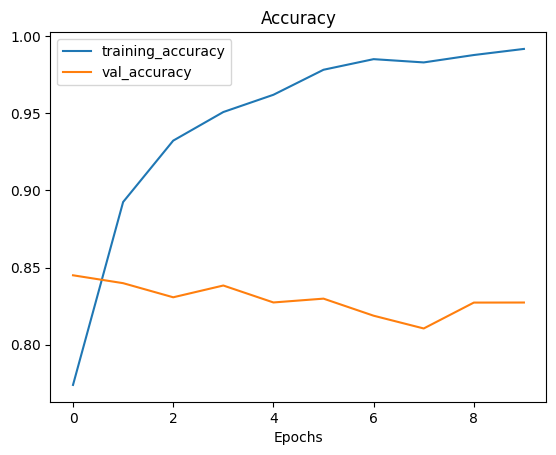

In [33]:
hf.plot_loss_curves(history_1)

# BiLSTM Model

In [36]:
dropout = 0.2

inputs = tf.keras.Input(shape = [PADDING_LEN],name = 'input_layer')
x = layers.Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_LEN, 
                       mask_zero = True, batch_input_shape = [BATCH_SIZE, None])(inputs)
x = layers.Bidirectional(layers.LSTM(units = 64, return_sequences = True))(x)
x = layers.Dropout(rate = 0.2)(x)
x = layers.Bidirectional(layers.LSTM(units = 64))(x)
x = layers.Dropout(rate = 0.2)(x)
outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2')

model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 224, 32)           640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 224, 128)         49664     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 224, 128)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0   

In [38]:
history_2 = model_2.fit(train_ds, epochs = 10,
            steps_per_epoch = len(train_ds),
            validation_data = val_ds,
            validation_steps = len(val_ds),
            callbacks = [hf.create_model_checkpoint(monitor = 'val_accuracy', model_name = model_2.name)])

model_2.load_weights('checkpoints/model_2.h5')
model_2.evaluate(val_ds)

Epoch 1/10
782/782 [==============================] - 160s 176ms/step - loss: 0.4390 - accuracy: 0.7926 - val_loss: 0.3422 - val_accuracy: 0.8492
Epoch 2/10
782/782 [==============================] - 58s 74ms/step - loss: 0.2467 - accuracy: 0.9043 - val_loss: 0.4000 - val_accuracy: 0.8453
Epoch 3/10
782/782 [==============================] - 52s 67ms/step - loss: 0.1650 - accuracy: 0.9406 - val_loss: 0.4203 - val_accuracy: 0.8303
Epoch 4/10
782/782 [==============================] - 51s 65ms/step - loss: 0.1160 - accuracy: 0.9606 - val_loss: 0.5265 - val_accuracy: 0.8296
Epoch 5/10
782/782 [==============================] - 48s 62ms/step - loss: 0.0752 - accuracy: 0.9749 - val_loss: 0.5895 - val_accuracy: 0.8209
Epoch 6/10
782/782 [==============================] - 48s 61ms/step - loss: 0.0480 - accuracy: 0.9836 - val_loss: 0.7936 - val_accuracy: 0.8150
Epoch 7/10
782/782 [==============================] - 48s 62ms/step - loss: 0.0311 - accuracy: 0.9890 - val_loss: 0.8675 - val_accurac

[0.34215864539146423, 0.8492400050163269]

In [39]:
results_2 = calculate_results(model_2, val_ds)
results_2

782/782 [==============================] - 4s 5ms/step


{'accuracy': 0.8378,
 'precision': 0.839285100283853,
 'recall': 0.8378,
 'f1': 0.8376223123046916}

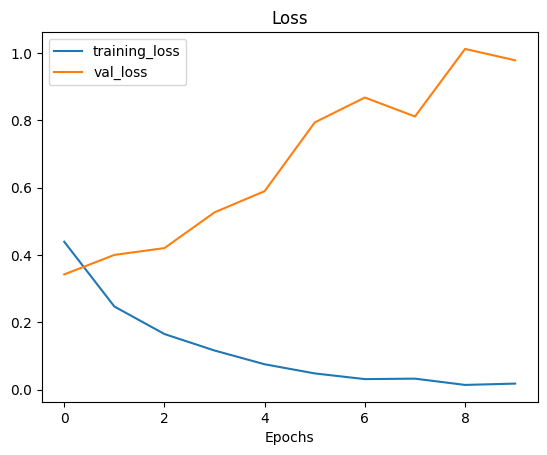

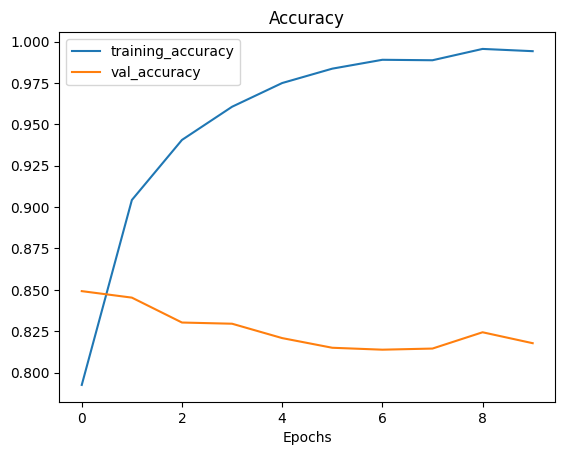

In [40]:
hf.plot_loss_curves(history_2)

In [41]:
results = pd.DataFrame({model_1.name : results_1,
                        model_2.name : results_2}).transpose().sort_values(by = 'f1', ascending = False)

results

,accuracy,precision,recall,f1
model_1,0.84496,0.845065,0.84496,0.844948
model_2,0.83780,0.839285,0.83780,0.837622


In [42]:
model_1.save('best_model')

In [43]:
loaded_model = tf.keras.models.load_model('best_model')

In [44]:
loaded_model.evaluate(val_ds)

782/782 [==============================] - 8s 6ms/step - loss: 0.4042 - accuracy: 0.8378


[0.404236763715744, 0.8378000259399414]

## End of the Document